In [23]:
from numpy import mean, corrcoef, array
import math
from scipy import stats
import scipy as sp
from sklearn import datasets, linear_model
import pandas as pd
import json
import matplotlib.pyplot as plt
import numpy as np
import datetime
from sklearn.decomposition import PCA

class Summary(object):
    def __init__(self, dataframe, age, samp_wtIndex, primarykey):
        header_names = list(dataframe)
        temp = dataframe.values.tolist()
        temp.insert(0, header_names)
        
        self.primarykey = primarykey
        self.data = temp
        self.view = dataframe
        self.age = age
        self.samp_wt = samp_wtIndex

    def mean(self, lowerboundage=0, upperboundage=999):
        avgdict = {}
        floatdum = 3.0
        for col in range(len(self.data[0])):
            avglist = []
            sampwtlist = []
            
            if col == self.primarykey:
                continue
            
            for line in self.data[1:]:

                if line[self.age] >= lowerboundage and line[self.age] <= upperboundage and type(line[col]) == type(floatdum):
                    avglist.append(line[col])
                    sampwtlist.append(line[self.samp_wt])
                
            avgdict[self.data[0][col]] = np.mean(avglist) 

        self.make_pretty(avgdict,"MEANS:")
        return avgdict

    def make_pretty(self,dictionary,titlestring):
        print("\n" + titlestring)
        keylist = sorted(dictionary.keys())
        for key in keylist:
            if len(key) < 8 :
                print(key + '\t\t' + str(dictionary[key]))
            else:
                print(key + '\t' + str(dictionary[key]))

    def __str__(self):
        return "There are {} observations and {} variables in this dataset.".format(len(self.data),len(self.data[0]))

    #returns the Pearson Correlation coefficient of each row in the dataset to a variable
    def corr(self, x=-2, y=-1):
        corrdict = {}
        repeat = False
        if y >= 0:
            collist = [y]
        elif y < 0:
            collist = range(len(self.data[0]))
        else:
            print("Please enter a valid input")
            quit()

        for col in collist:
            corrlistx = []
            corrlisty= []
            for line in self.data:
                if type(line[x]) == type(1.2):
                    corrlistx.append(line[x])
                elif type(line[x]) != type(1.2):
                    corrlistx.append('.')

                if type(line[col]) == type(1.2):
                    corrlisty.append(line[col])
                else:
                    corrlisty.append('.')

            try:
                corrdict[self.data[0][col]] = stats.pearsonr(*self.findmissing(corrlistx,corrlisty))
            except:
                print("Cannot perfom correlation on", self.data[0][col])

        self.make_pretty(corrdict,"CORRELATIONS: (r, p-value)")
        print (corrdict)
        return corrdict

    #throws away values where at least one value is missing
    def findmissing(self,corrlist1,corrlist2):
        for i in range(len(corrlist1)):
            try:
                if corrlist1[i] != type(1.2):
                    del corrlist1[i]
                    del corrlist2[i]
            except: pass

        for i in range(len(corrlist2)):
            try:
                if corrlist2[i] != type(1.2):
                    del corrlist1[i]
                    del corrlist2[i]
            except: pass
        return (corrlist1, corrlist2)

class Methods(object):
    def __init__(self, dataframe, cache_fname, age, genderindex, primarykey, samp_wt, output):
        # convert DataFrame to List Format
        header_names = list(dataframe)
        temp = dataframe.values.tolist()
        temp.insert(0, header_names)
        
        self.data = temp
        self.age = age
        self.genderindex = genderindex
        self.primarykey = primarykey
        self.samp_wt= samp_wt
        self.cache_fname = cache_fname
        try:
            cache_fhnd = open(self.cache_fname,'r')
            self.CACHE_DICT = json.loads(cache_fhnd.read())
            cache_fhnd.close()
        except:
            self.CACHE_DICT = {}
        self.AGEON = True 
        self.GRAPHON = True 
        self.savepath = output
        
        self.GroupSet = pd.unique(dataframe[header_names[self.genderindex]].values)

        if len(self.GroupSet) > 2:
            raise ValueError('There are more than 2 groups in this dataset')

    def pca(self):
        finaldict = {}

        for sex in self.GroupSet:
            if sex == "Male":
                sexname = "Males"
            else: sexname = "Females"

            if str(sex) in self.CACHE_DICT:
                self.calcLR(sex=sex,cachedict = self.CACHE_DICT[str(sex)]) 
                finaldict[sex] = self.calcBA(correctiondict = self.correctionterm(self.calcBA()))
            else:
                self.calcLR(sex=sex) 
                finaldict[sex] = self.calcBA(correctiondict = self.correctionterm(self.calcBA()))

        if 'BA' not in self.data[0]:
            for row in self.data:
                for sexkey in finaldict:
                    for key in finaldict[sexkey]:
                        if key == row[self.primarykey]: 
                            row.append(finaldict[sexkey][key])
        if 'BA' not in self.data[0]:
            self.data[0].append('BA')
        if 'BAC' not in self.data[0]:
            self.data[0].append('BAC')

        path = self.savepath
        fopen = open(path,'w+')
        
        for row in self.data:
            for i in range(len(row)):
                row[i] = str(row[i])
            fopen.write(",".join(row) + "\n")

        fopen.close()
        #print("DONE!")
        return self.data

    #REMEMBER TO CONSIDER SEX IN THIS...CALCLR CALCULATES FOR ONLY ONE SEX AT A TIME BUT YOU NEED A DICTIONARY THAT ACCOUNTS FOR BOTH
    def correctionterm(self, datatuple, agemax = 24, agemin = 36): # changed months to 2-3 years
        m = datatuple[1] 
        BAdict = datatuple[0] 
        n = len(self.newdata)-1
        delcounter = 0

        CorrectedBAdict = {}
        
        for row in self.newdata:
            try:
                row.append(BAdict[row[self.primarykey]][0])
            except:
                del(row)
                delcounter += 1

        if delcounter > 0: 
            print("Warning: %d rows deleted. Check the integrity of the data or check the code." % (delcounter))
        errcalc  = []
        for row in self.newdata:
            BA = row[-1]
            errcalc.append(BA - row[self.age])
        errcalc = np.array(errcalc)

        for row in self.newdata:
            rchar = BAdict[row[self.primarykey]][1]
            stderr = (np.var(errcalc) - (((1-(rchar**2))/(rchar**2)) * (((agemax - agemin)**2)/(12*m))))
            
            if self.AGEON == True:
                agecorrector = 5/(agemax-agemin)
                std = np.sqrt(stderr) - 2.5 + (agecorrector * row[self.age]) 
                stderr = std ** 2

            CorrectedBAdict[row[self.primarykey]] = stderr

        return CorrectedBAdict
    #############
    def cov(self, x, y, w):
        """Weighted Covariance"""
        return np.sum(w * (x - np.average(x, weights = w)) * (y - np.average(y, weights = w))) / np.sum(w)

    def corr(self, x, y, w):
        """Weighted Correlation"""
        return self.cov(x, y, w) / np.sqrt(self.cov(x, x, w) * self.cov(y, y, w))
    #############

    def calcBA(self, correctiondict={}):
        BasicBAdict = {}
        CorrectedBAdict = {}

        if correctiondict == {}:
            for row in self.newdata:
                numeratorlist = []
                denominatorlist = []
                rcharlistnumerator = []
                rcharlistdenominator = []
                for key in self.regressiondict:
                    covar = self.regressiondict[key] 
                    k = covar[0] 
                    s = covar[3] 
                    q = covar[1] 
                    r = covar[2] 

                    colindex = self.heading.index(key) 

                    try:
                        numeratorlist.append((row[colindex]-q)*(k/(s**2)))
                        denominatorlist.append((k/s)**2)
                        rcharlistnumerator.append(((r**2)/(math.sqrt(1-(r**2)))))
                        rcharlistdenominator.append((r/(math.sqrt(1-(r**2)))))
                    except:
                        print("r:",r, "var:", key)
                        quit()
                rchar = sum(rcharlistnumerator)/sum(rcharlistdenominator)

                BasicBAdict[row[self.primarykey]] = (sum(numeratorlist)/sum(denominatorlist), rchar)
            return (BasicBAdict,len(self.regressiondict))
        else:
            for row in self.newdata:
                numeratorlist = []
                denominatorlist = []
                for key in self.regressiondict:
                    covar = self.regressiondict[key] 
                    k = covar[0] 
                    s = covar[3] 
                    q = covar[1] 
                    r = covar[2]
                    colindex = self.heading.index(key)

                    numeratorlist.append((row[colindex]-q)*(k/(s**2))+(row[self.age]/correctiondict[row[self.primarykey]]))
                    denominatorlist.append(((k/s)**2)+(1/correctiondict[row[self.primarykey]]))

                CorrectedBAdict[row[self.primarykey]] = sum(numeratorlist)/sum(denominatorlist)
            return CorrectedBAdict

    def calcLR(self, sex="Male", cachedict = {}):
        #creates a new dataset for ONLY females or only males
        self.newdata = [line for line in self.data if line[self.genderindex] == "" or line[self.genderindex] == sex]
        self.df = pd.DataFrame(self.newdata[1:],columns=self.data[0])
        self.heading = list(self.df)
        self.regressiondict = {} 
        if sex == "Male":
            sexname = "Males"
        else:
            sexname = "Females"
        if cachedict == {}:
            #print("Calculating regressions for %s..." % (sexname))
            for idx,col in enumerate(self.heading):
                if idx in [self.age, self.primarykey, self.genderindex, self.samp_wt]:
                    continue
                
                regX = np.array(self.df[list(self.df)[self.age]]).reshape(-1, 1) 
                regY = np.array(self.df[[col]]) 

                regr = linear_model.LinearRegression()

                try:
                  weight = np.array(self.get_column(self.samp_wt)).reshape(len(self.get_column(self.samp_wt)),1)

                  regr.fit(regX,regY,sample_weight=self.get_column(self.samp_wt))

                  if self.GRAPHON == True:
                      plt.scatter(regX, regY,  color='black')
                      plt.plot(regX, regr.predict(regX), color='blue', linewidth=3)
                      plt.xticks(())
                      plt.yticks(())
                      plt.title('%s vs Age' % (col))
                      plt.xlabel('age')
                      plt.ylabel(col)
                      plt.show()

                  slope = regr.coef_[0][0]
                  intercept = regr.intercept_[0]
                  r_value = self.corr(regX, regY, weight) 
                  print(r_value)
                  std_err = math.sqrt(mean((regr.predict(regX) - regY) ** 2))

                except:
                    print("Cannot do LINEAR REGRESSION analysis for %s" % (col))
                    slope = 0
                    intercept = 0
                    r_value = 0
                    std_err = 0

                if slope and intercept and r_value and std_err != 0:
                    self.regressiondict[col] = (slope, intercept, r_value, std_err)

            cache_fhnd = open(self.cache_fname,'w')
            self.CACHE_DICT[str(sex)] = self.regressiondict
            cache_fhnd.write(json.dumps(self.CACHE_DICT))
            cache_fhnd.close()
        else:
            self.regressiondict = cachedict
        return self.regressiondict

    def make_pretty(self,dictionary,titlestring):
        print("\n" + titlestring)
        keylist = sorted(dictionary.keys())
        for key in keylist:
            if len(key) < 8 :
                print(key + '\t\t' + str(dictionary[key]))
            else:
                print(key + '\t' + str(dictionary[key]))

    def get_column(self,col):
        column = [line[col] for line in self.newdata]
        return column[1:]

    def cleandata(self,col1,col2):
        for i in range(len(col1)):
            try:
                if col1[i] != type(1.2):
                    del col1[i]
                    del col2[i]
            except: pass

        for i in range(len(col2)):
            try:
                if col2[i] != type(1.2):
                    del col1[i]
                    del col2[i]
            except: pass
        if len(col1) == len(col2):
            return (col1, col2)
        else:
            print("Cannot match data by length, check data dimensions.")
            return (len(col1), len(col2))



class Visualize(object):
    def __init__(self,data):
        self.data = data

    def view(self):
        return self.data

    def plot(self, inp1, inp2, inp3, min, max):
        new_df = pd.DataFrame()

        new_df[inp1] = pd.to_numeric(self.data[inp1])
        new_df[inp2] = pd.to_numeric(self.data[inp2])
        new_df[inp3] = self.data[inp3]
        
        for group in pd.unique(new_df[inp3]):
            fig, ax = plt.subplots(figsize=(5,5))
            plt.scatter(new_df[new_df[inp3] == group][inp1],
                        new_df[new_df[inp3] == group][inp2], s = 20, c ="orange")
            plt.xlim(min, max)
            plt.ylim(min, max)
            ax.legend(group)
            ax.plot([0, 1], [0, 1], transform=ax.transAxes)
            plt.ylabel(inp1)
            plt.xlabel(inp2)
            
            plt.show()

def pca_model(trainset, testset, cachename, output_filename, age_index, genderindex, primaryindex, samp_wt_index):

    # Build model
    output_filename_train = output_filename + '_train.csv'
    model = Methods(trainset, cachename, age = age_index, genderindex = genderindex, primarykey = primaryindex, samp_wt = samp_wt_index, output = output_filename_train)
    model.pca() 

    # test using trained model
    output_filename_test = output_filename + '_test.csv'
    test_model = Methods(testset, cachename, age = age_index, genderindex = genderindex, primarykey = primaryindex, samp_wt = samp_wt_index, output = output_filename_test)
    results = test_model.pca()
    results = pd.DataFrame(results[1:], columns = results[0])

    stats = return_stats(results['BAC'].astype('float64'), results[list(results)[age_index]].astype('float64'))
    
    return (stats)

def return_stats(x,y, dec=3):
    slope, intercept, r_value, p_value, std_err = sp.stats.linregress(x,y)
    
    Mr = abs(x-y).mean()
    Medr = np.median(abs(x-y))
    Mpr = np.median(100*abs((x-y)/x))
    rs = r_value**2
    print(r_value)
    
    return(Mr, Medr, Mpr, p_value, rs)



print('You are running BA_NB_Final at', datetime.datetime.now())





You are running BA_NB_Final at 2022-05-13 02:17:21.763063


In [24]:
import csv
import numpy as np
import pandas as pd

df = pd.read_excel (r'/content/sample_data/OppScrData.xlsx')
df = df.iloc[:, 0:52]  
#CT data
CT_DATA =  df.iloc[:, 42:52]
#clinical outcomes
OUTCOME = df.iloc[:, 15:42]
#clinical data
CLINICAL_DATA = df.iloc[:, 0:15]

OUTCOMES = pd.concat([OUTCOME, CLINICAL_DATA[["Record ID"]]], axis = 1, join="inner")



In [25]:
# import bio_age as BA
import pandas as pd
import scipy as sp #scipy for regressions
import numpy as np

subset_clinical_data = CLINICAL_DATA[["Record ID", "Age at CT", "Sex"]]
trainset = pd.concat([subset_clinical_data, CT_DATA], axis=1, join="inner")
trainset['samp_wt'] = np.random.uniform(0.0, 1.0, trainset.shape[0])
trainset["Liver HU    (Median)"] = pd.to_numeric(trainset["Liver HU    (Median)"], errors='coerce')
trainset["Age at CT"] = pd.to_numeric(trainset["Age at CT"], errors='coerce')
trainset.fillna(0, inplace=True)
trainset.head()

header_names = list(trainset)
age_index = header_names.index('Age at CT')
genderindex = header_names.index('Sex') # this is the name of the group
seqn = header_names.index('Record ID')
samp_wt_index = header_names.index('samp_wt')

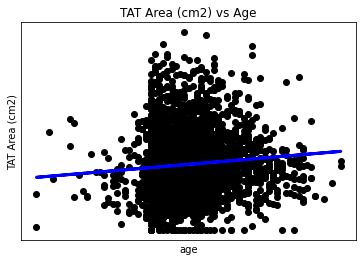

0.09253455064834265


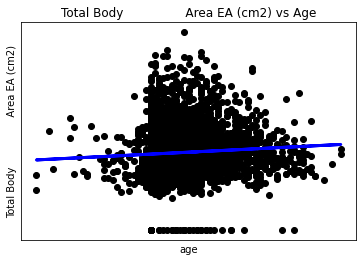

0.07140603360601275


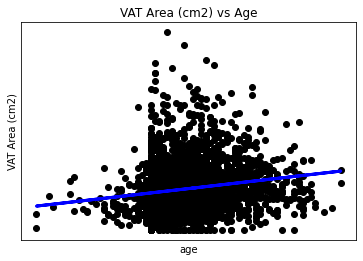

0.16553779219889597


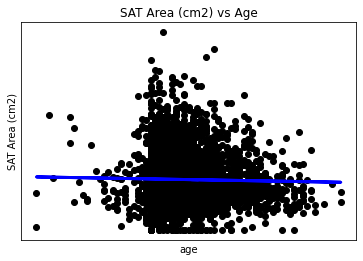

-0.022815668815786557


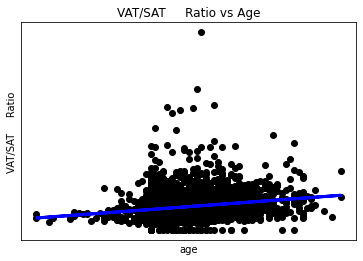

0.20512476460681056


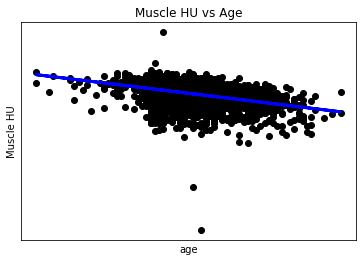

-0.39181124962438646


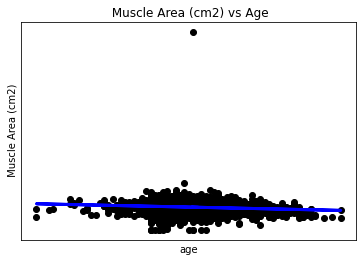

-0.12431842927937507


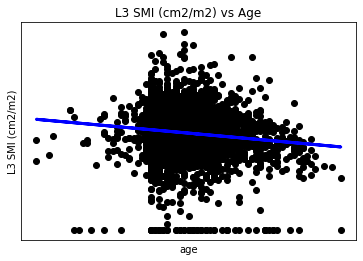

-0.12281831882183156


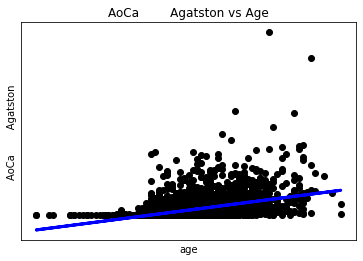

0.44097152430808373


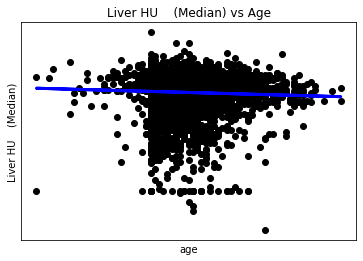

-0.04262100524462101


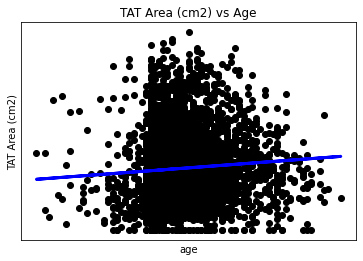

0.07440440891921392


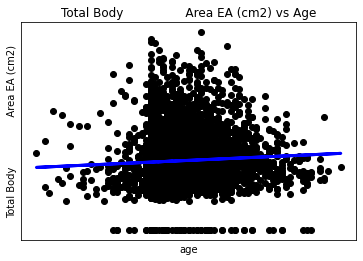

0.05932679143588404


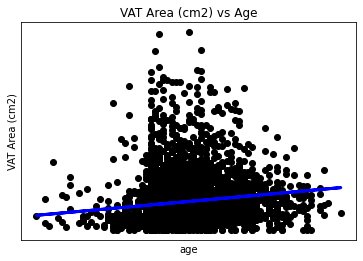

0.1361530833315022


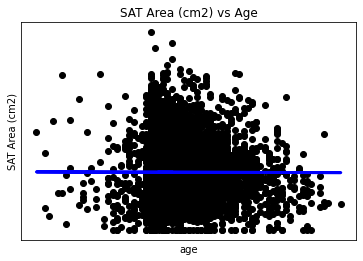

-0.0026298275452437702


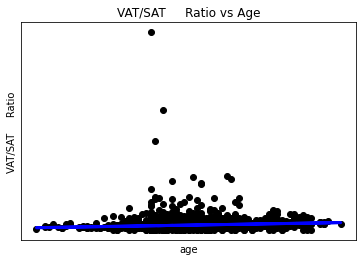

0.10139120903050053


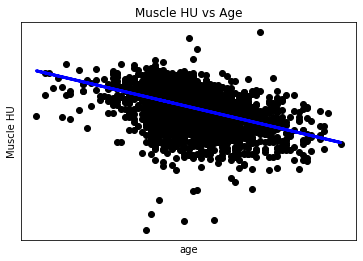

-0.4529305532394431


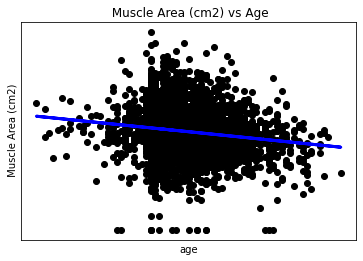

-0.15925865551705992


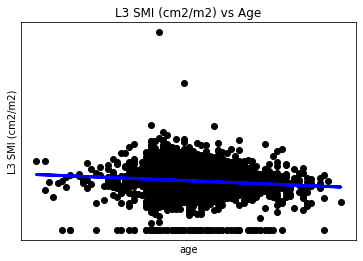

-0.10948573711790954


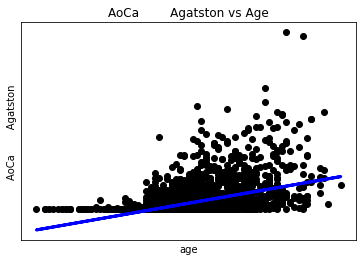

0.49219603506118215


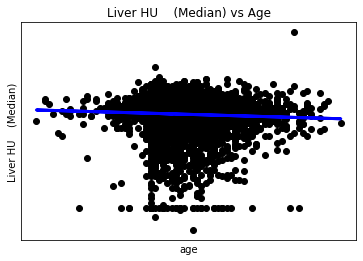

-0.051935979147391655
0.9474827469322501
Mean residual: 1.5529297944428417
Median residual: 0.9475784796994802
Median percent residual 1.717345868839988
R-squared: 0.8977235557342823


In [26]:
# all age groups
results = pca_model(trainset, trainset, 'cache_ex1.json', 'NHANES_eg_results', age_index, genderindex, seqn, samp_wt_index)
print('Mean residual:', results[0])
print('Median residual:', results[1])
print('Median percent residual', results[2])
print('R-squared:', results[4])

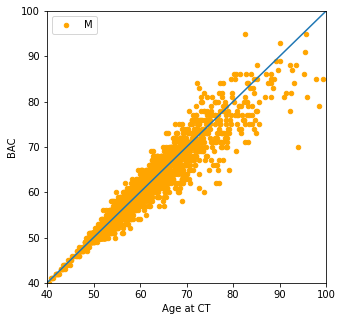

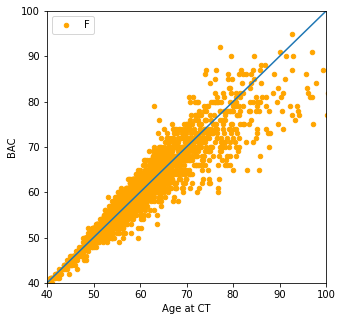

In [27]:
results = pd.read_csv('/content/NHANES_eg_results_test.csv')
a = Visualize(results)
a.plot('BAC','Age at CT','Sex', 40, 100)